In [2]:
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from ipywidgets import Button, HBox, VBox, Layout
from IPython.display import display, clear_output

import numpy as np
import time

import cv2
from torchvision import transforms as T

from scripts.custom_transformations import repeat_color_channel, min_max_normalization, ConvertToUint8, ConvertToFloat32
from scripts.custom_transformations import ConvertToFloat64, sample_frames, PermuteDimensions

In [3]:
!jupyter nbextension enable --py widgetsnbextension
!jupyter nbextension enable --py ipywidgets

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: contrib dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert nbextensions_configurator notebook run
server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtim

In [4]:
class ClipVisualizer:
    def __init__(self, dataset):
        self.dataset = dataset
        self.num_clips = len(dataset)
        self.current_clip_idx = 0
        self.clip = dataset[self.current_clip_idx]

        self.num_frames = self.clip[0].shape[1]
        self.current_frame = 0

        self.fig, self.ax = plt.subplots()
        
        self.img = self.ax.imshow(self.clip[0][0][self.current_frame])
        self.ax.set_title(f'Clip {self.current_clip_idx + 1}/{self.num_clips}, Frame {self.current_frame + 1}/{self.num_frames}')

        self.bprev_frame = Button(description='Prev Frame')
        self.bprev_frame.on_click(self.prev_frame)

        self.bnext_frame = Button(description='Next Frame')
        self.bnext_frame.on_click(self.next_frame)

        self.bprev_clip = Button(description='Prev Clip')
        self.bprev_clip.on_click(self.prev_clip)

        self.bnext_clip = Button(description='Next Clip')
        self.bnext_clip.on_click(self.next_clip)

        self.jump_10_frames_button = Button(description='Jump 10 Frames')
        self.jump_10_frames_button.on_click(self.jump_10_frames)
       
        self.update_display()

    def update_display(self):
        clear_output(wait=True)
        self.fig.canvas.draw()
        display(self.fig)
        #display(VBox([HBox([self.bprev_clip, self.bprev_frame, self.bnext_frame, self.bnext_clip])]))
        display(HBox([self.bprev_clip, self.bprev_frame, self.bnext_frame, self.bnext_clip, self.jump_10_frames_button]))


    def update_frame(self):
        clear_output(wait=True)
        self.img.set_data(self.clip[0][0][self.current_frame])
        self.ax.set_title(f'Clip {self.current_clip_idx + 1}/{self.num_clips}, Frame {self.current_frame + 1}/{self.num_frames} Action: {self.clip[1]}')
        self.fig.canvas.draw()
        display(self.fig)
        display(HBox([self.bprev_clip, self.bprev_frame, self.bnext_frame, self.bnext_clip,self.jump_10_frames_button]))

 
    def jump_10_frames(self, event):
        if self.current_frame + 10 < self.num_frames:
            self.current_frame += 10
        else:
            self.current_frame = self.num_frames - 1
        self.update_frame()


    def prev_frame(self, event):
        if self.current_frame > 0:
            self.current_frame -= 1
            self.update_frame()

    def next_frame(self, event):
        if self.current_frame < self.num_frames - 1:
            self.current_frame += 1
            self.update_frame()

    def prev_clip(self, event):
        if self.current_clip_idx > 0:
            self.current_clip_idx -= 1
            self.clip = self.dataset[self.current_clip_idx]
            self.num_frames = self.clip[0].shape[1]
            self.current_frame = 0
            self.update_frame()

    def next_clip(self, event):
        if self.current_clip_idx < self.num_clips - 1:
            self.current_clip_idx += 1
            self.clip = self.dataset[self.current_clip_idx]
            self.num_frames = self.clip[0].shape[1]
            self.current_frame = 0
            self.update_frame()

In [5]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import math
import cv2
# train = 2/3
# val = 1/6
# test = 1/6

class MRSActivityDataset(Dataset):

    def __init__(self, root_dir,max_number_frames, remove_background = False,
                  mode = "train" ,transform=None, eval_mode = "cs", get_metadata = False) -> None:
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode
        self.labels =[]
        self.clips = []
        self.room = []
        self.edition = []
        self.subjects = []
        self.max_number_frames = max_number_frames
        self.get_metadata = get_metadata
        self.meta_data = {
            "clip_lengths": [],
            "filenames": [],
            "labels": [],}
        self.remove_background = remove_background
        self.subject_selector()

        #walk through root_dir and create list of images and labels
        for root, dirs, files in os.walk(root_dir):
            for file in files:
                naming_list = file.split('_')

                action = int(naming_list[0][1:])
                subject = int(naming_list[1][1:])
                edition = int(naming_list[2][1:])

                self.clips.append(os.path.join(root, file))
                self.labels.append(action)
                self.subjects.append(subject)
                self.edition.append(edition)

                if self.get_metadata:
                    #read in the clip and get the length
                    len_current_clip = self.__getitem__(len(self.clips)-1)[0].shape[1]
                    self.meta_data["clip_lengths"].append(len_current_clip)


        print("#########################################")
        print(len(self.clips))
        print("#########################################")
        # print min max and quartiels of clip lengths
        if self.get_metadata:
            print("min clip length: ", np.min(self.meta_data["clip_lengths"]))
            print("25th percentile: ", np.percentile(self.meta_data["clip_lengths"], 25))
            print("50th percentile: ", np.percentile(self.meta_data["clip_lengths"], 50))
            print("75th percentile: ", np.percentile(self.meta_data["clip_lengths"], 75))
            print("max clip length: ", np.max(self.meta_data["clip_lengths"]))

            #save clip lengths to file
            np.save("/data2/fhuemer/MSRActivity3D/metadata/clip_lengths.npy", self.meta_data["clip_lengths"])

       
   
    def subject_selector(self):
        subjects = list(range(1,10))
        if self.mode == "train": 
            #leave out every third subject
            self.chosen_subjects = [x for x in subjects if x % 3 != 0]
        elif self.mode == "test":
            raise NotImplementedError
            self.chosen_subjects = subjects[2::3]
        elif self.mode == "val":
            self.chosen_subjects = subjects[2::3]

    def repeat_or_cutoff(self, clip):
        #repeat or cut off frames to max_number_frames
        if clip.shape[0] < self.max_number_frames:
            clip = np.repeat(clip, math.ceil(self.max_number_frames/clip.shape[0]) + 1 , axis=0)
            clip = clip[:self.max_number_frames, :, :, :]
        elif clip.shape[0] > self.max_number_frames:
            clip = clip[:self.max_number_frames, :, :, :]
        return clip

    def __len__(self):
        return len(self.clips)

    def __getitem__(self, idx):
        # returns sample and label for index 
        clip_path = self.clips[idx]
        label = self.labels[idx]
        clip = self.load_depth_map(clip_path)

        #add chanel dimension
        clip = np.expand_dims(clip, axis=3)

        #repeat or cut off frames to max_number_frames to get even number of frames
        clip = self.repeat_or_cutoff(clip)
        
        #here the dimensons get rearranged to fit the pytorch format. Watch out! 
        if self.transform:
            clip = self.transform(clip)

        return clip, label 

    def load_depth_map(self, depth_file, resize='VGA'):
        ''' Extracts depth images and masks from the MSR Daily Activites dataset
        ---Parameters---
        depth_file : filename for set of depth images (.bin file)
        '''

        file_ = open(depth_file, 'rb')

        ''' Get header info '''
        frames = np.frombuffer(file_.read(4), dtype=np.int32)[0]
        cols = np.frombuffer(file_.read(4), dtype=np.int32)[0]
        rows = np.frombuffer(file_.read(4), dtype=np.int32)[0]

        ''' Get depth/mask image data '''
        data = file_.read()

        '''
        Depth images and mask images are stored together per row.
        Thus we need to extract each row of size n_cols+n_rows
        '''
        dt = np.dtype([('depth', np.int32, cols), ('mask', np.uint8, cols)])

        ''' raw -> usable images '''
        frame_data = np.frombuffer(data, dtype=dt)
        depthIms = frame_data['depth'].astype(np.uint16).reshape([frames, rows, cols])
        maskIms = frame_data['mask'].astype(np.uint16).reshape([frames, rows, cols])


        depthIms = np.stack([cv2.resize(depthIms[d,:,:], (640,480)) for d in range(len(depthIms))],0)
        maskIms = np.stack([cv2.resize(maskIms[d,:,:], (640,480)) for d in range(len(maskIms))],0)

        if self.remove_background:
            binary_mask = (maskIms > 0).astype(np.uint16)
            depthIms = depthIms * binary_mask	
        depthIms = np.flip(depthIms, 1)
        
        return depthIms


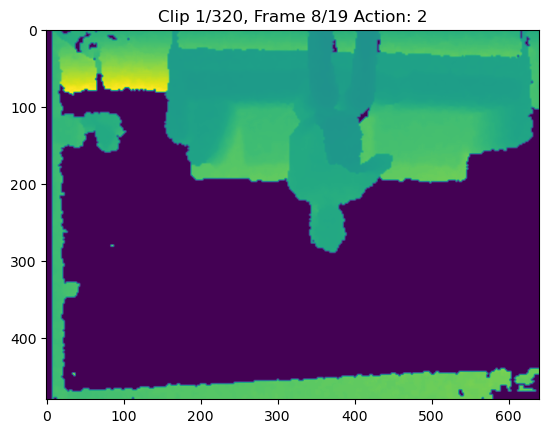

In [7]:
train_transform = T.Compose([
    min_max_normalization(scale_up=False),
    ConvertToFloat32(),
    PermuteDimensions(order=[3, 0, 1, 2]),
    repeat_color_channel(),
    sample_frames(nth=4),
])
train_set =  MRSActivityDataset(
    root_dir=r"/data/fhuemer/MSRActivity3D/data",
    mode = "train",
    transform=train_transform,
    max_number_frames = 75,

)


visualizer = ClipVisualizer(train_set)

__________________________________

In [ ]:
def read_header(file,dtype):
    # Read the number of frames
    num_frames = np.frombuffer(file.read(4), dtype=dtype)[0]
    # Read the dimensions of the frames
    dims = np.frombuffer(file.read(8), dtype=dtype)
    return dims, num_frames

def load_depth_map(path,dtype = np.uint32):
    with open(path, 'rb') as file:
        # Read header
        dims, num_frames = read_header(file, dtype)
        # Read the rest of the file data as uint32
        file_data = np.fromfile(file, dtype=dtype)
    
    #depth = file_data.astype(np.float64)
    # Convert to depth map format
    dims = (dims[0], dims[1])
    depth_count_per_map = np.prod(dims)
    #num_frames = len(file_data)//(dims[0]*dims[1])
    depth_maps = []

    #file_data = file_data[::-1]

    for _ in range(num_frames):
        current_depth_data = file_data[:depth_count_per_map]
        file_data = file_data[depth_count_per_map:]
        depth_map = current_depth_data.reshape((dims[0], dims[1]))
        depth_maps.append(depth_map)

    depth_maps = np.stack(depth_maps, axis=0)
    return depth_maps

def show_depth_map(depth_map):
    depth_map = np.array(depth_map)
    plt.imshow(depth_map, cmap='viridis', origin='lower')
    plt.gca().invert_yaxis()  # Reverse Y-axis
    plt.axis([0, depth_map.shape[1], 0, depth_map.shape[0]])
    plt.colorbar()
    plt.show()


# depth_sequence = load_depth_map(r"/data/fhuemer/Depth/a18_s07_e02_sdepth.bin")
depth_sequence = load_depth_map(r"/data/fhuemer/test_activity/a02_s09_e02_depth.bin")
show_depth_map(depth_sequence[1])

--------------------------------------------

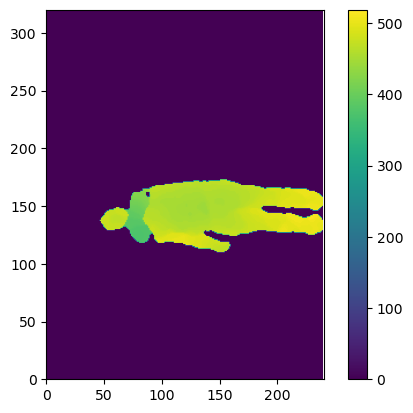

In [27]:
def load_depth_map(path):
    """
    This function reads a depth image from MSR Action3D dataset.
    
    Parameters:
    path (str): Location of the .bin file.
    
    Returns:
    depth_map (list of np.ndarray): List of depth images.
    """
    def read_header(fid):
        num_frames = np.frombuffer(fid.read(4), dtype=np.uint32)[0]
        dims = [np.frombuffer(fid.read(4), dtype=np.uint32)[0],
                np.frombuffer(fid.read(4), dtype=np.uint32)[0]]
        return dims, num_frames

    # READING FROM FILE
    with open(path, 'rb') as fid:
        dims, num_frames = read_header(fid)
        file_data = np.fromfile(fid, dtype=np.uint32)

    # CONVERTING TO DEPTH MAP FORMAT
    depth = file_data
    #depth = file_data.astype(np.float64)
    depth_count_per_map = np.prod(dims)

    depth_map = []
    for i in range(num_frames):
        current_depth_data = depth[:depth_count_per_map]
        depth = depth[depth_count_per_map:]
        depth_map.append(current_depth_data.reshape(dims[1], dims[0]).T)  # Reshape and transpose to match MATLAB output

    return depth_map





depth_map = load_depth_map(r"/data/fhuemer/Depth/a18_s07_e02_sdepth.bin")
#depth_map = load_depth_map(r"/data/fhuemer/MSRActivity3D/data/a10_s06_e02_depth.bin")
#depth_map = load_depth_map(r"/data/fhuemer/test_activity/a02_s09_e02_depth.bin")
show_depth_map(depth_map[30])

Number of frames: 159


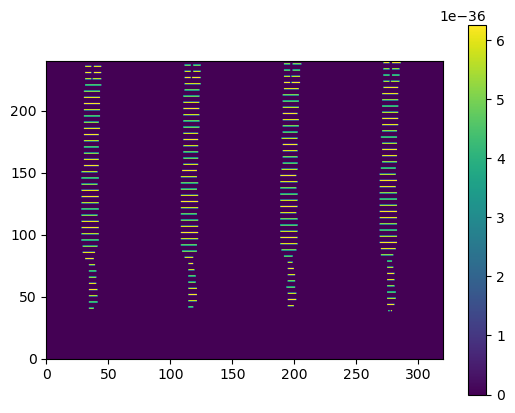

In [33]:
import numpy as np

def read_header(file):
    nofs = np.frombuffer(file.read(4), dtype=np.int32)[0]
    ncols = np.frombuffer(file.read(4), dtype=np.int32)[0]
    nrows = np.frombuffer(file.read(4), dtype=np.int32)[0]
    return nofs, ncols, nrows

def read_next_frame(file, ncols, nrows):
    size = ncols * nrows
    frame_data = np.fromfile(file, dtype=np.float32, count=size)
    return frame_data.reshape((nrows, ncols))

def load_depth_map(path):
    with open(path, 'rb') as file:
        nofs, ncols, nrows = read_header(file)
        print(f"Number of frames: {nofs}")
        depth_maps = []
        for _ in range(nofs):
            depth_map = read_next_frame(file, ncols, nrows)
            depth_maps.append(depth_map)
            non_zero_points = np.count_nonzero(depth_map)
            avg_non_zero_depth = np.mean(depth_map[depth_map > 0])
            #print(f"Frame {_}, ncols={ncols}, nrows={nrows}, count={non_zero_points}, avg={avg_non_zero_depth:.2f}")
    return depth_maps



depth_file_path = "/data/fhuemer/MSRActivity3D/data/a10_s06_e02_depth.bin"
depth_maps = load_depth_map(depth_file_path)
show_depth_map(depth_maps[0])


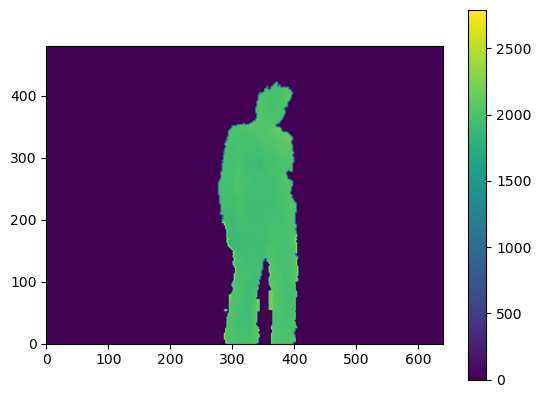

In [5]:
def read_MSR_depth_ims(depth_file, resize='VGA'):
	''' Extracts depth images and masks from the MSR Daily Activites dataset
	---Parameters---
	depth_file : filename for set of depth images (.bin file)
	'''

	file_ = open(depth_file, 'rb')

	''' Get header info '''
	frames = np.frombuffer(file_.read(4), dtype=np.int32)[0]
	cols = np.frombuffer(file_.read(4), dtype=np.int32)[0]
	rows = np.frombuffer(file_.read(4), dtype=np.int32)[0]

	''' Get depth/mask image data '''
	data = file_.read()

	'''
	Depth images and mask images are stored together per row.
	Thus we need to extract each row of size n_cols+n_rows
	'''
	dt = np.dtype([('depth', np.int32, cols), ('mask', np.uint8, cols)])

	''' raw -> usable images '''
	frame_data = np.frombuffer(data, dtype=dt)
	depthIms = frame_data['depth'].astype(np.uint16).reshape([frames, rows, cols])
	maskIms = frame_data['mask'].astype(np.uint16).reshape([frames, rows, cols])

	if resize == 'VGA':
		# embed()
		depthIms = np.dstack([cv2.resize(depthIms[d,:,:], (640,480)) for d in range(len(depthIms))])
		maskIms = np.dstack([cv2.resize(maskIms[d,:,:], (640,480)) for d in range(len(maskIms))])

	binary_mask = (maskIms > 0).astype(np.uint16)
	masked_depthIms = depthIms * binary_mask	

	masked_depthIms = np.flip(masked_depthIms, axis=0)
	return masked_depthIms, binary_mask


def show_depth_map(depth_map):
    depth_map = np.array(depth_map)
    plt.imshow(depth_map, cmap='viridis', origin='lower')
    plt.gca().invert_yaxis()  # Reverse Y-axis
    plt.axis([0, depth_map.shape[1], 0, depth_map.shape[0]])
    plt.colorbar()
    plt.show()


depth_file_path = "/data/fhuemer/MSRActivity3D/data/a10_s06_e02_depth.bin"
depth_maps = read_MSR_depth_ims(depth_file_path)
show_depth_map(depth_maps[0][:,:,75])